In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots are configured to be rendered as images because otherwise they won't display correctly on GitHub or when the notebook is loaded (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.

# Temperature and humidity forecasting with LSTM

This notebook showcases the LSTM forecatser of [Timeseria](https://github.com/sarusso/Timeseria).

Let's start by loading an example time series, and resample it to one hour:

In [2]:
from timeseria import TEST_DATASETS_PATH
from timeseria.datastructures import TimeSeries
timeseries = TimeSeries.from_csv(TEST_DATASETS_PATH + 'humitemp_long.csv').resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 615.0s
[INFO] timeseria.transformations: Resampled 17910 DataTimePoints in 3191 DataTimePoints


In [3]:
# Have a look at the time series
timeseries

Time series of #3191 points at 1h resolution, from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1557961200.0 (2019-05-15 23:00:00+00:00)

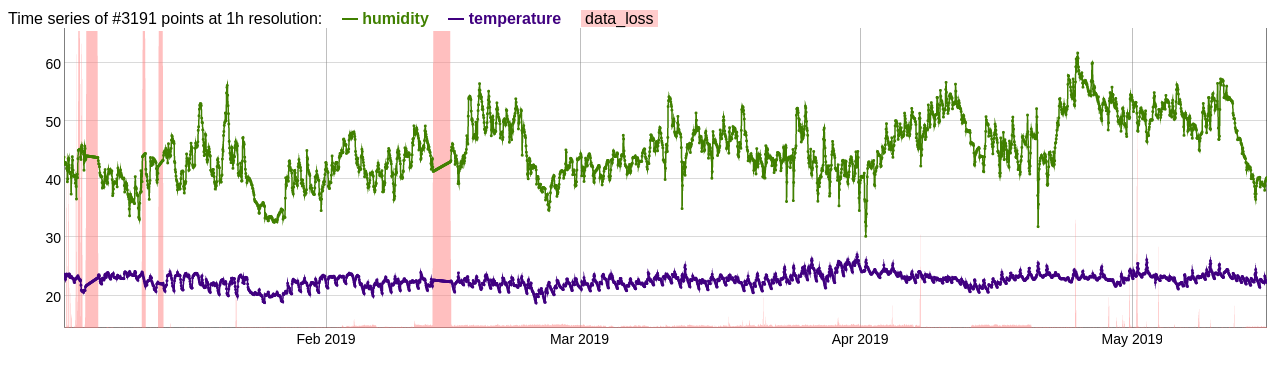

In [4]:
# Plot the time series
timeseries.plot()

## Model fit, usage and evaluation

In [5]:
from timeseria.models import LSTMForecaster

# Instantiate and fit the model
forecaster = LSTMForecaster()
forecaster.fit(timeseries, epochs=10, verbose=False, reproducible=True)

[INFO] timeseria.models.forecasters: Using default window size of 3
[INFO] timeseria.models.forecasters: Using default features: values


In [6]:
# Call the predict() function of the model. This returns key-value data with the prediction values
forecaster.predict(timeseries)

{'humidity': 40.36904406029075, 'temperature': 22.397075612066637}

In [7]:
# The timeseries on which to call the predict has to be at least of 24 hours (the window length)
try:
    forecaster.predict(timeseries[0:23])
except Exception as e:
    print(e)

In [8]:
# The forecats() method returns not only data but also their data points, with the timestamp
forecaster.forecast(timeseries)

Time point @ 1557964800.0 (2019-05-16 00:00:00+00:00) with data "{'humidity': 40.36904406029075, 'temperature': 22.397075612066637}"

In [9]:
# The apply() method allows instead to directly apply the model on a time series
# (by combining the forecasts with the real observations).
timeseries_with_forecast = forecaster.apply(timeseries, steps=24)

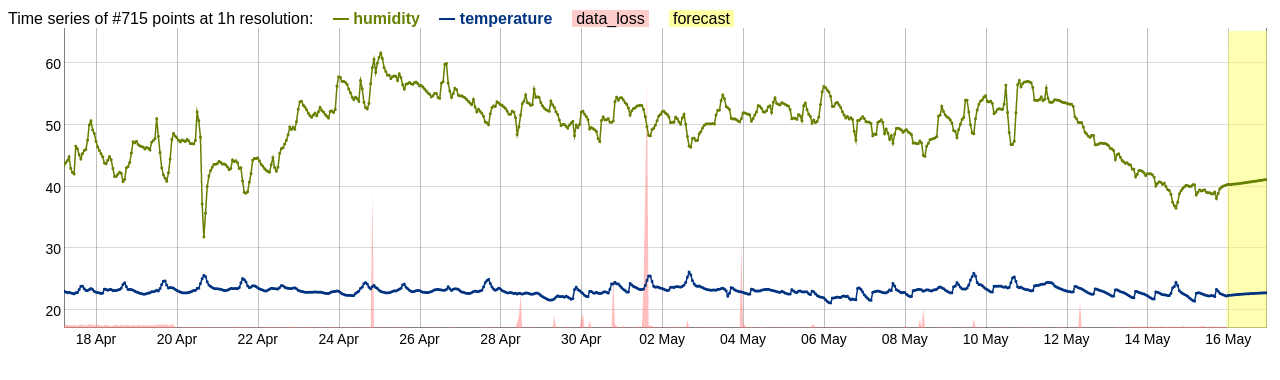

In [10]:
# Plot the last part of the time series together with the prediction
timeseries_with_forecast[2500:].plot()